In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy import stats
from scipy import constants
import time as time
from itertools import chain

import torch
import torch.nn as nn
from torch.nn import ReLU
import torch.utils.data as td
from torch.utils.data import DataLoader
import torch.nn.functional as F


from sklearn.preprocessing import  MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import multilabel_confusion_matrix

In [3]:
# trainning and validation data
all_data=pd.read_csv('feat_25_prob1.csv',index_col=False,header=None)
shuffled_data=all_data.sample(frac = 1)
# feature=pd.read_csv('features.csv',index_col=False,header=None)
# target=pd.read_csv('target.csv',index_col=False,header=None)
feature=shuffled_data.iloc[:, 0:25]
target=shuffled_data.iloc[:, 25]

In [4]:
### Reading values only for trainning data
feature_in=feature.values
target_in=target.values

# converting to tensor train data
feature_tensor=torch.Tensor(feature_in)[0:2000]
target_tensor=torch.Tensor(target_in)[0:2000]

# converting to tensor test data
feature_tensor_test=torch.Tensor(feature_in)[2000:3000]
target_tensor_test=torch.Tensor(target_in)[2000:3000]

In [5]:
batch_size_train=10
train=[*zip(feature_tensor,target_tensor)]
train_loader= DataLoader(train,batch_size=batch_size_train,shuffle=True)


for image,labels in train_loader:
        print('Initial Batch shape:',image.size())
        break
print('batch shape after flattening',image.view(10,-1).size())

batch_size_test=1000
test=[*zip(feature_tensor_test,target_tensor_test)]
test_loader= DataLoader(test,batch_size=batch_size_test,shuffle=True)

Initial Batch shape: torch.Size([10, 25])
batch shape after flattening torch.Size([10, 25])


In [23]:
# Trainned on PCA input with 2 hidden layers
neuron_list=[64,32]

class MLP_hidden(nn.Module):
        def __init__(self,input_size=25,output_size=10,layers=neuron_list):
                super().__init__()
                self.x1=nn.Linear(input_size,layers[0])
                self.x2=nn.Linear(layers[0],layers[1])
                self.x3=nn.Linear(layers[1],output_size)
                self.dropout = nn.Dropout(0.25)

        def forward(self,X):
                X=F.relu(self.x1(X))
                X = self.dropout(X)
                X=F.relu(self.x2(X))
                X = self.dropout(X)
                X= self.x3(X)
                return F.log_softmax(X,dim=1)

model=MLP_hidden()
print(model)

MLP(
  (x1): Linear(in_features=25, out_features=64, bias=True)
  (x2): Linear(in_features=64, out_features=32, bias=True)
  (x3): Linear(in_features=32, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [ ]:
# Trainned on PCA input with no hidden layers

neuron_list=[64,32]

class MLP_no_hidden(nn.Module):
        def __init__(self,input_size=25,output_size=10,layers=neuron_list):
                super().__init__()
                self.x1=nn.Linear(input_size,layers[0])
                self.x2=nn.Linear(layers[0],layers[1])
                self.x3=nn.Linear(layers[1],output_size)
                self.dropout = nn.Dropout(0.25)

        def forward(self,X):
                # X=F.relu(self.x1(X))
                # X = self.dropout(X)
                # X=F.relu(self.x2(X))
                # X = self.dropout(X)
                X= self.x1(X)
                return F.log_softmax(X,dim=1)

model=MLP_no_hidden()
print(model)

# just call the model from class for the trainning just run any one of above and trainn it

In [24]:
criterion=nn.CrossEntropyLoss()
learning_rate=0.001
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate)
epochs =20
train_loss=[] ## for storing the trainning loss
test_losses=[] ## for storing the test loss
train_correct=[]## correct prediction store
epoch_nums = []
train_acc=[]
y_act=[] ## for storing actual as batch wise giving

start = time.perf_counter()
 
for i in range(epochs):
        trn_corr=0
        tst_corr=0
       
        for b,(X_train,y_train) in enumerate(train_loader):
                b+=1
                y_act.append(y_train) ## Storing actual output
                y_pred=model(X_train)
                loss=criterion(y_pred,torch.flatten(y_train).type(torch.LongTensor))

                predicted=torch.max(y_pred.data,1)[1]
                train_correct.append(predicted)## Storing prediction
                batch_corr=(predicted==torch.flatten(y_train).type(torch.LongTensor)).sum() ## counting batch correct...long tensor is used to make them as per requirement
                
                trn_corr+=batch_corr

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
               
                if b%200 == 0:
                        epoch_nums.append(i)
                        train_loss.append(loss)  
                        
                        print(f'epoch:{i:2} batch: {b:4} Train loss: {(loss)} Train accuracy: {((trn_corr/2000)*100)} ')
                        train_acc.append((trn_corr/2000)*100)
                        # print(batch_corr)
                
                
# record end time
end = time.perf_counter()
 
# find elapsed time in seconds
ms = (end-start) 
test_correct=[]
y_act_test=[]
with torch.no_grad():
        for b,(X_test,y_test) in enumerate(test_loader):
                y_val=model(X_test) # prediction from the trainned model
                y_act_test.append(y_test)# test actual label stoired
                predicted_test=torch.max(y_val.data,1)[1] ## softmax maximum probability choseing as output
                test_correct.append(predicted_test)
                tst_corr+=(predicted_test==torch.flatten(y_test).type(torch.LongTensor)).sum() ## counting correct prediction
                
loss_test= criterion(y_val,torch.flatten(y_test).type(torch.LongTensor))
score_test = metrics.accuracy_score(predicted_test, y_test)
test_losses.append(loss)
test_correct.append(tst_corr)## this is appending the number of correct predicted

print(f'Test loss: {loss_test} Test accuracy: {round((score_test)*100,3)} Time taken for training(sec)={round(ms,3)}')

epoch: 0 batch:  200 Train loss: 3.307600736618042 Train accuracy: 15.75 
epoch: 1 batch:  200 Train loss: 2.322540760040283 Train accuracy: 54.10000228881836 
epoch: 2 batch:  200 Train loss: 1.8812448978424072 Train accuracy: 69.5 
epoch: 3 batch:  200 Train loss: 1.4749850034713745 Train accuracy: 76.0 
epoch: 4 batch:  200 Train loss: 1.0551167726516724 Train accuracy: 78.64999389648438 
epoch: 5 batch:  200 Train loss: 1.2901479005813599 Train accuracy: 80.29999542236328 
epoch: 6 batch:  200 Train loss: 1.3231121301651 Train accuracy: 81.5999984741211 
epoch: 7 batch:  200 Train loss: 0.9744480848312378 Train accuracy: 82.4000015258789 
epoch: 8 batch:  200 Train loss: 0.4574311673641205 Train accuracy: 82.9000015258789 
epoch: 9 batch:  200 Train loss: 0.48701947927474976 Train accuracy: 83.75 
epoch:10 batch:  200 Train loss: 0.628175675868988 Train accuracy: 84.0999984741211 
epoch:11 batch:  200 Train loss: 0.9663190841674805 Train accuracy: 84.8499984741211 
epoch:12 batch: 

In [25]:
trn_cor=[]
for i in range(len(train_correct)):
        train_correct_list=train_correct[i].detach().numpy()      ## loop to convert tensor into list of list
        trn_cor.append(train_correct_list)

final_train_correct = [int(item[0]) for item in trn_cor] ## predicted in train (list of list to single list)

y_cor=[]
for i in range(len(y_act)):
        y_cor_list=y_act[i].detach().numpy()
        y_cor.append(y_cor_list)

final_y_train = [int(item[0]) for item in y_cor]## actual in train (list of list to single list)


In [26]:
report_trainning=metrics.confusion_matrix(final_y_train,final_train_correct) # due to batching we need to make this the input to confusion matrix
# sklearn.metrics.confusion_matrix
report_trainning
cm_df_trainning = pd.DataFrame(report_trainning,
                     index = ['0','1','2','3','4','5','6','7','8','9'], #,labels=["0", "1", "2","3", "4", "5","6", "7", "8","9"]
                     columns = ['0','1','2','3','4','5','6','7','8','9'])
cm_df_trainning

ValueError: Shape of passed values is (48, 48), indices imply (10, 10)

In [ ]:
len(train_correct)

4000

In [ ]:
report_testing=metrics.confusion_matrix(predicted_test, y_test)  ##here number of count also getting stores
# sklearn.metrics.confusion_matrix
report_testing
cm_df_testing = pd.DataFrame(report_testing,
                     index = ['0','1','2','3','4','5','6','7','8','9'], #,labels=["0", "1", "2","3", "4", "5","6", "7", "8","9"]
                     columns = ['0','1','2','3','4','5','6','7','8','9'])
cm_df_testing

,0,1,2,3,4,5,6,7,8,9
0,95,0,2,2,1,1,3,0,0,0
1,0,97,3,1,0,0,0,0,3,0
2,1,0,78,0,1,0,3,2,3,2
3,2,1,1,89,0,8,1,0,4,1
4,0,1,4,0,83,0,2,1,4,10
5,4,0,0,8,3,83,5,0,3,3
6,1,0,1,1,1,2,90,0,3,0
7,0,1,7,0,0,2,0,87,0,11
8,0,4,1,1,0,1,1,1,75,3
9,0,0,1,1,3,0,0,6,6,70


<function matplotlib.pyplot.show(close=None, block=None)>

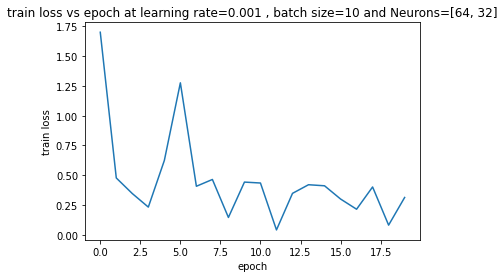

In [ ]:
tensor_trainning_loss = torch.tensor(train_loss, requires_grad=False)
plt.plot(epoch_nums,tensor_trainning_loss)
plt.xlabel("epoch")
plt.ylabel("train loss")
plt.title(f'train loss vs epoch at learning rate={learning_rate} , batch size={batch_size_train} and Neurons={neuron_list}' )
# plt.yticks(np.linspace(170,200,10))
plt.show
## plotting trainning error

<function matplotlib.pyplot.show(close=None, block=None)>

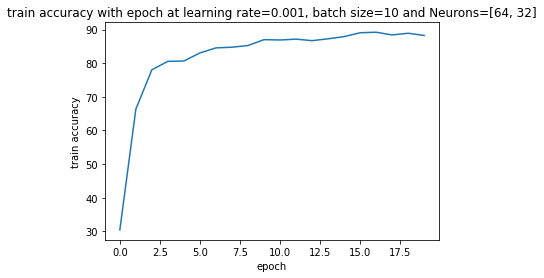

In [ ]:
# tensor_trainning_loss = torch.tensor(train_loss, requires_grad=False)
plt.plot(epoch_nums,train_acc)
plt.xlabel("epoch")
plt.ylabel("train accuracy")
plt.title(f'train accuracy with epoch at learning rate={learning_rate}, batch size={batch_size_train} and Neurons={neuron_list}')
# plt.yticks(np.linspace(170,200,10))
plt.show
## plotting trainning error

In [ ]:
kf = StratifiedKFold(5, shuffle=True, random_state=42)   ## K fold stratiufied as categorical need to be class balanced for regression only K fold will work

oos_y = []
oos_pred = []
fold = 0
score_collect=[]
for train, test in kf.split(feature_tensor,target_tensor):  
    fold+=1
    print(f"Fold #{fold}")
        
    x_train = (feature_tensor[train])
    y_train = (target_tensor[train])
    x_test =  (feature_tensor[test])
    y_test =  (target_tensor[test])
    # model=MLP()
    y_pred_cv=model(x_train)
    loss_cv=criterion(y_pred_cv,y_train.type(torch.LongTensor))
    predicted_cv=torch.max(y_pred_cv.data,1)[1]

    optimizer.zero_grad()
    loss_cv.backward()
    optimizer.step()


    with torch.no_grad():
        
        y_val=model(x_test)
        oos_y.append(y_test)

        predicted_test=torch.max(y_val.data,1)[1]
        oos_pred.append(predicted_test)
        score = metrics.accuracy_score(predicted_test, y_test)
        print(f"Fold score (accuracy): {score*100}")
        score_collect.append(score)
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)
oos_y_compare = np.argmax(oos_y)

# score = metrics.accuracy_score(oos_y_compare, oos_pred)
print(f"Final score (accuracy): {np.mean(score_collect)*100}")    


oos_y = pd.DataFrame(oos_y)
oos_pred = pd.DataFrame(oos_pred)


Fold #1
Fold score (accuracy): 90.75
Fold #2
Fold score (accuracy): 91.0
Fold #3
Fold score (accuracy): 89.5
Fold #4
Fold score (accuracy): 90.0
Fold #5
Fold score (accuracy): 90.25
Final score (accuracy): 90.3


In [ ]:
report=metrics.confusion_matrix(y_test,predicted_test)
# sklearn.metrics.confusion_matrix
report
cm_df = pd.DataFrame(report,
                     index = ['0','1','2','3','4','5','6','7','8','9'], #,labels=["0", "1", "2","3", "4", "5","6", "7", "8","9"]
                     columns = ['0','1','2','3','4','5','6','7','8','9'])
cm_df

,0,1,2,3,4,5,6,7,8,9
0,40,0,0,0,0,0,0,0,1,0
1,0,38,0,0,0,0,0,0,2,0
2,1,0,31,0,0,0,3,0,3,0
3,0,0,0,31,0,3,0,1,5,1
4,0,0,0,0,31,0,0,0,4,5
5,0,0,2,1,0,37,0,0,0,0
6,0,0,0,0,0,1,38,0,1,0
7,0,0,0,0,0,0,0,36,0,4
8,0,0,0,0,0,1,0,0,40,0
9,0,0,0,0,2,0,0,1,3,33


In [27]:
pixels = np.array(feature[30:31], dtype = 'int64')
print(pixels.shape)
# Reshape the array into 28 x 28 array (2-dimensional array)
pixels = pixels.reshape((28, 28))
print(pixels.shape)
# Plot
plt.title(f'{target[30:31]}')
plt.imshow(pixels, cmap='gray')
plt.show()

(1, 25)


ValueError: cannot reshape array of size 25 into shape (28,28)